<a href="https://colab.research.google.com/github/Dyl-cmyk/datascience/blob/projects/DylaLaurUnit9Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 9 Project: Your first neural network

##Intro

For this project i decided to use a kaggle dataset to train pyTorch to recgonize landscapes. The dataset I am using was designed specficically for this process and included a train dataset and a test dataset.

I had to do a little bit of research on how to get Pytorch to analyze images, but after that the hard part was over...not rlly...

Important Links For Doing the Project

[Dataset Page](https://www.kaggle.com/datasets/puneet6060/intel-image-classification/data)

[Learning How to make a CNN](https://machinelearningmastery.com/building-a-convolutional-neural-network-in-pytorch/)

[Learning how to read the code for a CNN](https://ubc-mds.github.io/DSCI_572_sup-learn-2/lectures/06_cnns-pt1.html)

In [2]:
import torch
import numpy as np
from torch import nn
from torchvision import datasets, transforms
import torch.optim as optim
import pandas as pd
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import kagglehub

# Download latest version and Importing Kaggle data
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/intel-image-classification


##Attempt 1 Doing my own tuning
I decided to use the code from the "learning how to make CNN" link and attempted to do the math on my own on what values Conv2d and fc3 need to be in order to run the neural network successfuly. I also attempted to do some of my own optimizing by changing the kernel size and padding to get it to run more smoothly.

In [2]:
data_train = path + '/seg_pred' # load training data from Kaggle
data_test = path + '/seg_test' # load test data from Kaggle

transform = transforms.Compose([transforms.ToTensor()])# TODO: compose transforms here

traindata = datasets.ImageFolder(data_train, transform=transform) # TODO: create the ImageFolder
testdata = datasets.ImageFolder(data_test, transform=transform)

trainloader = torch.utils.data.DataLoader(traindata, batch_size=32, shuffle=True) # TODO: use the ImageFolder dataset to create the DataLoader
testloader = torch.utils.data.DataLoader(testdata, batch_size=32, shuffle=True)

In [ ]:
class CIFAR10Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 150, kernel_size=(4,4), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.0)

        self.conv2 = nn.Conv2d(150, 150, kernel_size=(4,4), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.flat = nn.Flatten()

        self.fc3 = nn.Linear(821400, 32)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(32, 32)

    def forward(self, x):
        # input 3x10x10, output 10x10x10
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        # input 10x10x10, output 10x10x10
        x = self.act2(self.conv2(x))
        # input 10x10x10, output 10x5x5
        x = self.pool2(x)
        # input 10x5x5, output 821400
        x = self.flat(x)
        # input 821400, output 32
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        # input 32, output ?
        x = self.fc4(x)
        return x

model = CIFAR10Model()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

n_epochs = 20
for epoch in range(n_epochs):
    for inputs, labels in trainloader:
        # forward, backward, and then weight update
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    acc = 0
    count = 0
    for inputs, labels in testloader:
        y_pred = model(inputs)
        acc += (torch.argmax(y_pred, 1) == labels).float().sum()
        count += len(labels)
    acc /= count
    print("Epoch %d: model accuracy %.2f%%" % (epoch, acc*100))

torch.save(model.state_dict(), "cifar10model.pth")

RuntimeError: stack expects each tensor to be equal size, but got [3, 150, 150] at entry 0 and [3, 144, 150] at entry 30

Unfourtinatley I was never able to successufly tune this model to output a [3, 150, 150] model so i decided to ask Gemini if it could just give me the numbers i needed to run the neural network on my stock, 150x150 images

##Attempt 2 Gemini Resize

After Tinkering with gemini for a little bit it produced this output. I told it to make the code nearly identical to Attempt 1 but change the numbers so that the calculations would line up, and it did a pretty good job. One thing I didn't consider, though is that the 150x150 images would take a while...like 2+hrs a while. So, I decided to abandon this in favor of resizing the images down to 32x32

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

data_train = path + '/seg_pred' # load training data from Kaggle
data_test = path + '/seg_test' # load test data from Kaggle

transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Confirm image size is 150x150
    transforms.ToTensor(),
])

traindata = datasets.ImageFolder(data_train, transform=transform)
testdata = datasets.ImageFolder(data_test, transform=transform)

trainloader = torch.utils.data.DataLoader(traindata, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testdata, batch_size=32, shuffle=False)

# Modified CNN model
class CIFAR10Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 150, kernel_size=(4, 4), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.0)

        self.conv2 = nn.Conv2d(150, 150, kernel_size=(4, 4), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.flat = nn.Flatten()

        # Updated input size for fc3
        self.fc3 = nn.Linear(821400, 32)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(32, 32)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        x = self.act2(self.conv2(x))
        x = self.pool2(x)
        x = self.flat(x)
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        x = self.fc4(x)
        return x

# Model, loss function, and optimizer
model = CIFAR10Model()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training loop
n_epochs = 20
for epoch in range(n_epochs):
    for inputs, labels in trainloader:
        # forward, backward, and then weight update
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print training progress (optional)
    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}")

##Attempt 3 Image Resize down to 32x32

After Resizing the images It finally ran!! YAYAYAYA
While this is great news the 100% model accuracy over 20 epochs raises a few concerns about overfitting. So, lets check

In [5]:
data_train = path + '/seg_pred' # load training data from Kaggle
data_test = path + '/seg_test' # load test data from Kaggle

transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images to 32x32
    transforms.ToTensor(),
])

traindata = datasets.ImageFolder(data_train, transform=transform)
testdata = datasets.ImageFolder(data_test, transform=transform)

trainloader = torch.utils.data.DataLoader(traindata, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testdata, batch_size=32, shuffle=False)

class CIFAR10Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.flat = nn.Flatten()

        self.fc3 = nn.Linear(8192, 512)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(512, 10)

    def forward(self, x):
        # input 3x32x32, output 32x32x32
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        # input 32x32x32, output 32x32x32
        x = self.act2(self.conv2(x))
        # input 32x32x32, output 32x16x16
        x = self.pool2(x)
        # input 32x16x16, output 8192
        x = self.flat(x)
        # input 8192, output 512
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        # input 512, output 10
        x = self.fc4(x)
        return x

model = CIFAR10Model()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

n_epochs = 20
for epoch in range(n_epochs):
    for inputs, labels in trainloader:
        # forward, backward, and then weight update
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    acc = 0
    count = 0
    for inputs, labels in testloader:
        y_pred = model(inputs)
        acc += (torch.argmax(y_pred, 1) == labels).float().sum()
        count += len(labels)
    acc /= count
    print("Epoch %d: model accuracy %.2f%%" % (epoch, acc*100))

torch.save(model.state_dict(), "cifar10model.pth")

Epoch 0: model accuracy 100.00%
Epoch 1: model accuracy 100.00%
Epoch 2: model accuracy 100.00%
Epoch 3: model accuracy 100.00%
Epoch 4: model accuracy 100.00%
Epoch 5: model accuracy 100.00%
Epoch 6: model accuracy 100.00%
Epoch 7: model accuracy 100.00%
Epoch 8: model accuracy 100.00%
Epoch 9: model accuracy 100.00%
Epoch 10: model accuracy 100.00%
Epoch 11: model accuracy 100.00%
Epoch 12: model accuracy 100.00%
Epoch 13: model accuracy 100.00%
Epoch 14: model accuracy 100.00%
Epoch 15: model accuracy 100.00%
Epoch 16: model accuracy 100.00%
Epoch 17: model accuracy 100.00%
Epoch 18: model accuracy 100.00%
Epoch 19: model accuracy 100.00%


Unfourtinatley its a little bit hard to "check" data without it being quantative, so the best thing I have is trying to redue the accuracy to like 99%r or 98%

##Attempt 4 Reducing overfitting

In [7]:
data_train = path + '/seg_pred' # load training data from Kaggle
data_test = path + '/seg_test' # load test data from Kaggle

transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images to 32x32
    transforms.ToTensor(),
])

traindata = datasets.ImageFolder(data_train, transform=transform)
testdata = datasets.ImageFolder(data_test, transform=transform)

trainloader = torch.utils.data.DataLoader(traindata, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testdata, batch_size=32, shuffle=False)

class CIFAR10Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        #increased dropout from 0.3 -> 0.7
        self.drop1 = nn.Dropout(0.7)

        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.flat = nn.Flatten()

        self.fc3 = nn.Linear(8192, 512)
        self.act3 = nn.ReLU()
        #increased dropout from 0.5 -> 0.9
        self.drop3 = nn.Dropout(0.9)

        self.fc4 = nn.Linear(512, 10)

    def forward(self, x):
        # input 3x32x32, output 32x32x32
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        # input 32x32x32, output 32x32x32
        x = self.act2(self.conv2(x))
        # input 32x32x32, output 32x16x16
        x = self.pool2(x)
        # input 32x16x16, output 8192
        x = self.flat(x)
        # input 8192, output 512
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        # input 512, output 10
        x = self.fc4(x)
        return x

model = CIFAR10Model()
loss_fn = nn.CrossEntropyLoss()
#added decay per recomendation of gemini
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

n_epochs = 20
for epoch in range(n_epochs):
    for inputs, labels in trainloader:
        # forward, backward, and then weight update
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    acc = 0
    count = 2
    for inputs, labels in testloader:
        y_pred = model(inputs)
        acc += (torch.argmax(y_pred, 1) == labels).float().sum()
        count += len(labels)
    acc /= count
    print("Epoch %d: model accuracy %.2f%%" % (epoch, acc*100))

torch.save(model.state_dict(), "cifar10model.pth")

Epoch 0: model accuracy 99.93%
Epoch 1: model accuracy 99.93%
Epoch 2: model accuracy 99.93%
Epoch 3: model accuracy 99.93%
Epoch 4: model accuracy 99.93%
Epoch 5: model accuracy 99.93%
Epoch 6: model accuracy 99.93%
Epoch 7: model accuracy 99.93%
Epoch 8: model accuracy 99.93%
Epoch 9: model accuracy 99.93%
Epoch 10: model accuracy 99.93%
Epoch 11: model accuracy 99.93%
Epoch 12: model accuracy 99.93%
Epoch 13: model accuracy 99.93%
Epoch 14: model accuracy 99.93%
Epoch 15: model accuracy 99.93%
Epoch 16: model accuracy 99.93%
Epoch 17: model accuracy 99.93%
Epoch 18: model accuracy 99.93%
Epoch 19: model accuracy 99.93%


After messing with it for a little bit I managed to get the accuary down to a "less likely to be overfitting" and "probably pretty accurate" level. Ill take it!

###Attempting to add some sort of ppc
This code is based off of gemini's recomendation on how to create a ppc for a CNN...

In [9]:
data_train = path + '/seg_pred' # load training data from Kaggle
data_test = path + '/seg_test' # load test data from Kaggle

transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images to 32x32
    transforms.ToTensor(),
])

traindata = datasets.ImageFolder(data_train, transform=transform)
testdata = datasets.ImageFolder(data_test, transform=transform)

trainloader = torch.utils.data.DataLoader(traindata, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testdata, batch_size=32, shuffle=False)

class CIFAR10Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        #increased dropout from 0.3 -> 0.7
        self.drop1 = nn.Dropout(0.7)

        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.flat = nn.Flatten()

        self.fc3 = nn.Linear(8192, 512)
        self.act3 = nn.ReLU()
        #increased dropout from 0.5 -> 0.9
        self.drop3 = nn.Dropout(0.9)

        self.fc4 = nn.Linear(512, 10)

    def forward(self, x):
        # input 3x32x32, output 32x32x32
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        # input 32x32x32, output 32x32x32
        x = self.act2(self.conv2(x))
        # input 32x32x32, output 32x16x16
        x = self.pool2(x)
        # input 32x16x16, output 8192
        x = self.flat(x)
        # input 8192, output 512
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        # input 512, output 10
        x = self.fc4(x)
        #added softmax to output "probabilites instead of raw scores"- Gemini
        x = nn.Softmax(dim=1)(x)
        return x

model = CIFAR10Model()
loss_fn = nn.CrossEntropyLoss()
#added decay per recomendation of gemini
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

n_epochs = 20
for epoch in range(n_epochs):
    for inputs, labels in trainloader:
        # forward, backward, and then weight update
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    acc = 0
    count = 2
    for inputs, labels in testloader:
        y_pred = model(inputs)
        acc += (torch.argmax(y_pred, 1) == labels).float().sum()
        count += len(labels)
    acc /= count
    print("Epoch %d: model accuracy %.2f%%" % (epoch, acc*100))

torch.save(model.state_dict(), "cifar10model.pth")

Epoch 0: model accuracy 99.93%
Epoch 1: model accuracy 99.93%
Epoch 2: model accuracy 99.93%
Epoch 3: model accuracy 99.93%
Epoch 4: model accuracy 99.93%
Epoch 5: model accuracy 99.93%
Epoch 6: model accuracy 99.93%
Epoch 7: model accuracy 99.93%
Epoch 8: model accuracy 99.93%
Epoch 9: model accuracy 99.93%
Epoch 10: model accuracy 99.93%
Epoch 11: model accuracy 99.93%
Epoch 12: model accuracy 99.93%
Epoch 13: model accuracy 99.93%
Epoch 14: model accuracy 99.93%
Epoch 15: model accuracy 99.93%
Epoch 16: model accuracy 99.93%
Epoch 17: model accuracy 99.93%
Epoch 18: model accuracy 99.93%
Epoch 19: model accuracy 99.93%


In [10]:
#this code collects the perdictions from the testing data
train_preds = []
train_labels = []
for inputs, labels in trainloader:
    y_pred = model(inputs)
    train_preds.extend(y_pred.detach().numpy())
    train_labels.extend(labels.numpy())

test_preds = []
test_labels = []
for inputs, labels in testloader:
    y_pred = model(inputs)
    test_preds.extend(y_pred.detach().numpy())
    test_labels.extend(labels.numpy())

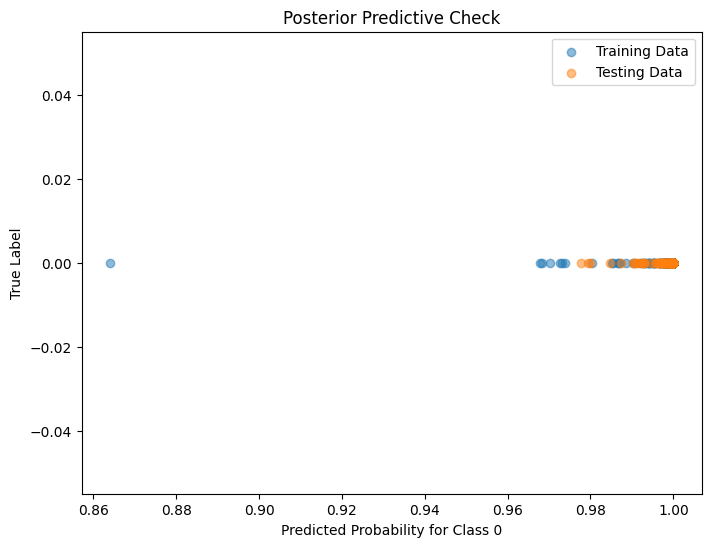

In [11]:
import matplotlib.pyplot as plt
#this should actually compare the training vs testing data...lets see
# Choose a class to compare (e.g., class 0)
class_index = 0

plt.figure(figsize=(8, 6))
plt.scatter(
    [p[class_index] for p in train_preds],
    train_labels,
    alpha=0.5,
    label="Training Data",
)
plt.scatter(
    [p[class_index] for p in test_preds],
    test_labels,
    alpha=0.5,
    label="Testing Data",
)
plt.xlabel(f"Predicted Probability for Class {class_index}")
plt.ylabel("True Label")
plt.title("Posterior Predictive Check")
plt.legend()
plt.show()

Looks pretty darn good!

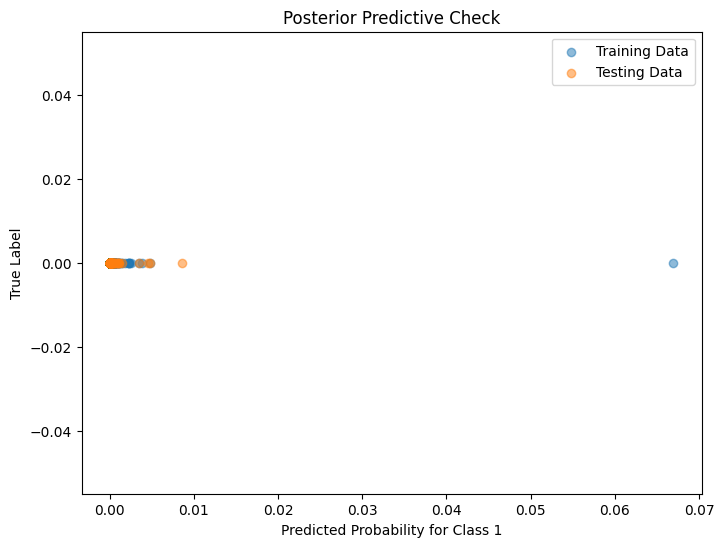

In [12]:
import matplotlib.pyplot as plt
#this should actually compare the training vs testing data...lets see
# Choose a class to compare (e.g., class 0)
class_index = 1

plt.figure(figsize=(8, 6))
plt.scatter(
    [p[class_index] for p in train_preds],
    train_labels,
    alpha=0.5,
    label="Training Data",
)
plt.scatter(
    [p[class_index] for p in test_preds],
    test_labels,
    alpha=0.5,
    label="Testing Data",
)
plt.xlabel(f"Predicted Probability for Class {class_index}")
plt.ylabel("True Label")
plt.title("Posterior Predictive Check")
plt.legend()
plt.show()

Here it is again on class 1 (a different image type for ex: waterfalls)

Overall it seems like this model is doing a pretty great job of perdicting which type of landscape this is supposed to be.

##Conclusion

Overall this project has taught me a lot, espically about the power of neural networks(I never realized how much data they processed). And, just like this course there is still so much to know, but! I am feel much more confident, not only with my python and dataskills. But also with my problem solving skills. This course has helped me learn how to think on my own and solve problems when working on unfimilar topics. Overall im very glad I took this course :)